Perform Imports

In [63]:
%matplotlib inline

import json
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas
from scipy.signal import butter, lfilter, freqz
from mpl_toolkits.mplot3d import Axes3D
from fastdtw import fastdtw, dtw
from pprint import pprint
from scipy.spatial.distance import euclidean, cityblock


Array for easily mapping joint IDs to joint names

In [64]:
JOINT_MAPPINGS = [
    "Ass",
    "Middle of the spine",
    "Neck",
    "Head",
    "Left Shoulder",
    "Left Elbow",
    "Left Wrist",
    "Left Hand",
    "Right Shoulder",
    "Right Elbow",
    "Right Wrist",
    "Right Hand",
    "Left Hip",
    "Left Knee",
    "Left Ankle",
    "Left Foot",
    "Right Hip",
    "Right Knee",
    "Right Ankle",
    "Right Foot",
    "Spine at the Shoulder"
]

### Pair of functions from stack overflow to perform lowpass filtering. 

https://stackoverflow.com/questions/25191620/creating-lowpass-filter-in-scipy-understanding-methods-and-units

In [65]:
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [66]:
# Filter specifications.
ORDER = 2
SAMPLE_RATE = 20.0      # sample rate in Hz
CUTOFF_F = 2.0  # cutoff frequency in Hz

### Function to perform unfiltered discrete derivative. For best results, filter your signal, then differentiate

In [67]:
def discrete_derivative(x,sample_rate=SAMPLE_RATE):
    derivative = np.array([x[i] - x[i-1] for i in range(1,len(x))])
    derivative = derivative*sample_rate
    return derivative

### Importing the data of the template lift and the series that is being identified.

In [68]:
TEMPLATE_FILE = open('lifts/Chris_Single_Squat_1.json')
MATCHING_FILE = open('lifts/Chris_Three_Squats_1.json')

template_data = json.load(TEMPLATE_FILE)
data = json.load(MATCHING_FILE)

In [69]:
template_frames =  template_data["Details"]["BodyData"]["Details"]["OrderedFrames"]
frames =  data["Details"]["BodyData"]["Details"]["OrderedFrames"]

In [70]:
template_ts = []
ts = []
for i in range(25):
    template_ts = template_ts + [{}]
    ts = ts + [{}]
    for c in ['X','Y','Z']:
        template_ts[i][c] = np.array([joint["Details"]["Joints"][i][c] for joint in template_frames])
        ts[i][c] = np.array([joint["Details"]["Joints"][i][c] for joint in frames])


### Get data for the height of the lower spine

In [71]:
template_ls_height = np.array([joint["Details"]["Joints"][0]['Y'] for joint in template_frames])
template_ls_height = template_ls_height[10:-3]
ls_height = np.array([joint["Details"]["Joints"][0]['Y'] for joint in frames])

### Standardize units as a percentage of D2F https://youtu.be/Tx3wDTzqDTs?t=1m20s

In [72]:
D2F_t = template_frames[0]["Details"]["Joints"][0]['Y'] - template_frames[0]["Details"]["Joints"][15]['Y']
D2F = frames[0]["Details"]["Joints"][0]['Y'] - frames[0]["Details"]["Joints"][15]['Y']
template_ls_height = template_ls_height/D2F_t
ls_height = ls_height/D2F

In [73]:
D2F_t

0.9067150516

In [74]:
D2F

0.93293650842

### Comparison between template and matching data.

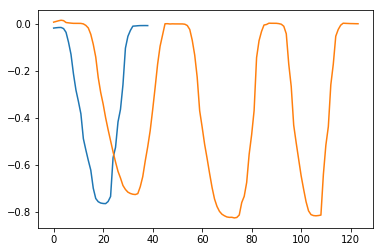

In [75]:
plt.plot(template_ls_height)
plt.plot(ls_height)

### Lower Spine velocity (unused)

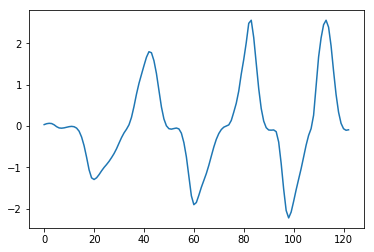

In [76]:
ls_height_filtered = butter_lowpass_filter(ls_height,CUTOFF_F,SAMPLE_RATE,ORDER)
plt.plot(discrete_derivative(ls_height_filtered))

### Creating a dissimilarity measure between the squat template and the signal starting at any potential offset. Conceptually, offsets with low dissimlarity look a lot like squat motions. The local minima of this series represent likely starting points for lifts.

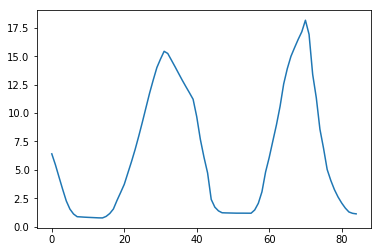

In [77]:
distances = []
for offset in range(len(ls_height)-len(template_ls_height)):
    distance, _ = fastdtw(template_ls_height, ls_height[offset:len(template_ls_height)+offset], radius = 1, dist=euclidean)
    distances = distances + [distance]
distances = np.array(distances)
plt.plot(distances)

In [78]:
#finding local minima
from scipy.signal import argrelextrema
minInd = argrelextrema(distances, np.less, order=5, mode="wrap")
minInd

(array([14, 55, 84], dtype=int32),)

### Plot of the squats identified within the lift session

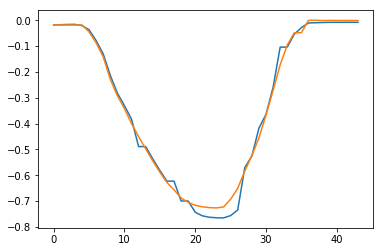

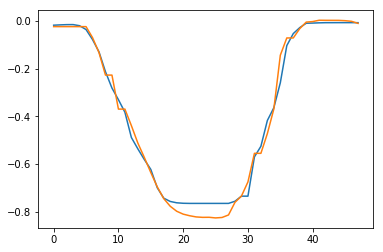

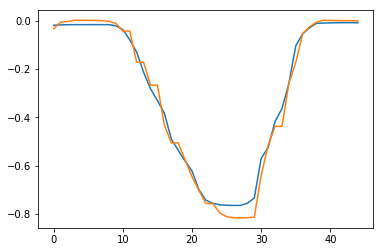

In [79]:
o = minInd[0][0]
for o in minInd[0]:
    plt.figure()
    distance, path = dtw(template_ls_height, ls_height[o:len(template_ls_height)+o], dist=euclidean)
    warped_t = np.array([template_ls_height[x[0]] for x in path])
    warped = np.array([ls_height[o:len(template_ls_height)+o][x[1]] for x in path])
    plt.plot(warped_t)
    plt.plot(warped)

### Analyzing squat depth, as an example

#### Finding the bottom of the squat
As a general solution to finding moments within a lift, we can use the warped timing of the template lift to indicate when specific event occur. ie: unwarped the bottom of the squat is frame 20, find what frame 20 maps to when warped, that indicates the bottom of the squat in the sampled lift.

This could be solved more easily, however we can generalize this solution to find arbitrary "moments" during a lift, not just simple mins, or maxs.

[<matplotlib.lines.Line2D at 0xfb66f0>, <matplotlib.lines.Line2D at 0xfb67d0>]

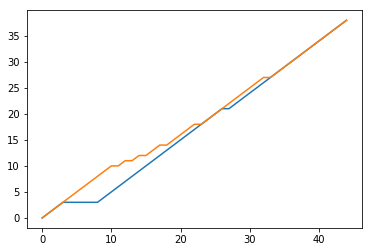

In [80]:
plt.plot(path)

In [81]:
[x[0] for x in path].index(20)

25

In [82]:
path[25][1] + minInd[0][2]

104

In [93]:
bfj = frames[104]["Details"]["Joints"] # bottom frame joints

In [84]:
rhh = bfj[16]['Y'] # right hip height
rhd = bfj[16]['Z'] # right hip depth
rkh = bfj[17]['Y'] # right knee height
rkd = bfj[17]['Z'] # right knee depth

In [85]:
def hip_knee_angle(hh,hd,kh,kd):
    delta_d = hd - kd
    delta_h = hh - kh
    return math.atan(delta_h/delta_d)*180/math.pi

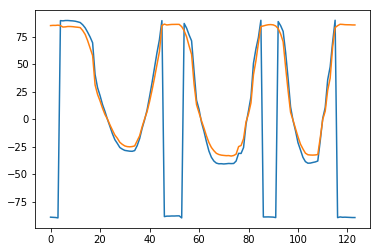

In [92]:
r_angle_ts =  [hip_knee_angle(ts[16]['Y'][i],ts[16]['Z'][i],ts[17]['Y'][i],ts[17]['Z'][i]) for i in range(len(ts[0]['X']))]
l_angle_ts =  [hip_knee_angle(ts[12]['Y'][i],ts[12]['Z'][i],ts[13]['Y'][i],ts[13]['Z'][i]) for i in range(len(ts[0]['X']))]
plt.plot(r_angle_ts)
plt.plot(l_angle_ts)
